# Convolutional Neural Networks on CIFAR-100

Lab Assignment One: Exploring Table Data

**_Jake Oien, Seung Ki Lee, Jenn Le_**

## Introduction

For this lab, we will be using the CIFAR-100 dataset. From its description: 

"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

The CIFAR-100 dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

Dataset source: http://www.cs.toronto.edu/~kriz/cifar.html

As requested, we will also cite Alex Krizhevsky's paper, Learning Multiple Layers of Features from Tiny Images (April 8, 2009) http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

## Business Case

When working with machine learning and datasets, it is important to have an idea about what problem is being solved, or what the value of applying a classification algorithm to some set of data. In the case of many image datasets that are used for machine learning, the problem that is being solved is simply "Can a machine learning algorithm distinguish different objects in images?" So, we will follow in the footsteps of past research, and see if we can develop a model that can detect different objects. 

This dataset is of note because it has superclasses and classes. This could provide a good mechanism for beginning to understand where an algorithm is failing to correctly classify images, because perhaps the algorithm can't detect people very well, but can do really well on classifying vehicles. 

In a deployment setting, our algorithm might be used as a helper for a search engine indexer. Given an image, a category output by the neural network might be used to associate with a given search term and improve on the effectiveness of the search engine. A rather high success rate should be expected for this, so as not to hinder the search engine's performance. In this specific situation, without using it in a real setting, it's impossible to know how well the neural network would need to do to be a help, so we will paraphrase a definition of obscenity in the US and say "We'll know it when we see it."

## Preparation

In [1]:
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

First, let's load the dataset. The training set contains 50000 images, and the test set contains 10000 images. The meta file contains the actual titles corresponding to numeric labels. We will be keeping the test set away from the train/test cycle, and so will call it our validation set. 

In [2]:
train = unpickle("cifar-100-python/train")
validation = unpickle("cifar-100-python/test")
meta = unpickle("cifar-100-python/meta")

X_train = train[b"data"]
X_validation = validation[b"data"]

y_train = train[b"fine_labels"]
y_validation = validation[b"fine_labels"]

label_names = meta[b"fine_label_names"]

### Preprocessing
  

The classes included in the dataset are shown below. To prepare our dataset, we decided to one hot encode the classes and normalize the pixel values from 0-255 to -1 to 1. We will be using the Classes column, but the Superclass column may come in useful for analyzing performance on the subclasses. 


| Superclass	|  Classes  |
| ----------- | --------- |
| aquatic mammals |	beaver, dolphin, otter, seal, whale |
| fish |	aquarium fish, flatfish, ray, shark, trout |
| flowers |	orchids, poppies, roses, sunflowers, tulips |
| food containers |	bottles, bowls, cans, cups, plates |
| fruit and vegetables |	apples, mushrooms, oranges, pears, sweet peppers |
| household electrical devices | clock, computer keyboard, lamp, telephone, television |
| household furniture |	bed, chair, couch, table, wardrobe |
| insects |	bee, beetle, butterfly, caterpillar, cockroach |
| large carnivores |	bear, leopard, lion, tiger, wolf |
| large man-made outdoor things |	bridge, castle, house, road, skyscraper |
| large natural outdoor scenes |	cloud, forest, mountain, plain, sea |
| large omnivores and herbivores |	camel, cattle, chimpanzee, elephant, kangaroo |
| medium-sized mammals |	fox, porcupine, possum, raccoon, skunk |
| non-insect invertebrates |	crab, lobster, snail, spider, worm |
| people |	baby, boy, girl, man, woman |
| reptiles |	crocodile, dinosaur, lizard, snake, turtle |
| small mammals |	hamster, mouse, rabbit, shrew, squirrel |
| trees	| maple, oak, palm, pine, willow |
| vehicles 1 |	bicycle, bus, motorcycle, pickup truck, train |
| vehicles 2 |	lawn-mower, rocket, streetcar, tank, tractor |

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

Using TensorFlow backend.


'2.0.7'

In [4]:
from sklearn.preprocessing import normalize

y_train_labels = [label_names[index] for index in y_train]
y_validation_labels = [label_names[index] for index in y_validation]
NUM_CLASSES = 100

# one hot encode the labels
y_train_ohe = y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_validation_ohe = keras.utils.to_categorical(y_validation, NUM_CLASSES)

In [5]:
# normalize the pixel values
X_train_scaled = normalize(X_train)
X_validation_scaled = normalize(X_validation)

Before we begin training, let's make sure we know what we're looking at as far as this dataset goes. 

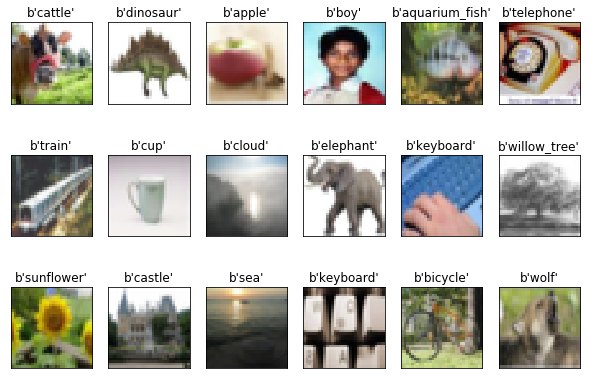

In [6]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        
        # this line is to get the images to display properly. 
        # Due to the way the data is stored, more has to be done on the data than the basic stuff in the example notebooks.
        # rot90(image, 1 rotation, (1,0)) does a 90 degree clockwise rotation
        # images[i].reshape((3,h,w)).T splits the image into its proper channels from its flattened form
        plt.imshow(np.rot90(images[i].reshape((3, h, w)).T, 1, (1,0)))
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train_labels, 32, 32) # defaults to showing a 3 by 6 subset

We think that converting these images to black and white would be too hard to recognize considering the low resolution, so we will be keeping the color channels. 

### Evaluation Metric

We will be using accuracy to measure the performance of the algorithm. Because we are just measuring the ability of the network to detect specific objects in images, we don't particularly care about any class over another, so false classifications don't weigh more or less either way. What we might run into is the existence of too many classes to effectively train the models on. For example, in the picture of the boy above, it is clear that that is a person, but it is difficult to tell the gender and even the age of the human in the picture. So, the model might correctly train to recognize humans, but might not be robust enough to tell the difference between the different kinds of humans. 

We may decide to collapse the classes back into the superclasses and see how the model does at landing in the larger category buckets while missing the exact class in that superclass. However, we chose to try out CIFAR-100 because of its relative difficulty, so we will be starting with it. 

### Training/Testing Split

For dividing our dataset, we will be using stratified 5-fold cross validation. We find that 10 folds is a common number of folds that gets used in cross validation techniques. With 50,000 training images, we may be approaching the point where averaging the results of folds will not provide as much confidence in the generalization performance of our model as simply having a better network architecture for the problem. Additionally, the per-model training time is greatly increased relative to our previous work. We will choose 5 folds as our trade-off between estimating generalization performance and training time. 

Additionally, we will be leaving out 10,000 samples to use in a validation set. So, the models will train on 50,000 samples, and will never see 10,000 more of them. We will be using those 10,000 samples (set aside in the "test" set in our dataset) as a validation set to evaluate the models' performances on a completely new set of data. 

We think a stratified method is a realistic mirroring of how an algorithm would be deployed because we have no reason to believe any of these classes would appear more often than others. So, we don't want to accidentally bias the models with more data from a given class. 

In practice, we would not use cross validation as a part of our deployed algorithm. We will use cross-validation to estimate the performances of different models, but once we have determined our best model, we will train it using all of our data and judge the performance of the algorithm on new images. 

## Modeling

In [48]:
from sklearn.model_selection import StratifiedKFold

### Part 1 of convolutional NN

img_wh = 32

# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

def create_cnn1():
    cnn = Sequential()
    cnn.add(Reshape((img_wh, img_wh, 3), input_shape=(1,3072)))

    num_filt_layers = [32, 64]
    for num_filters in num_filt_layers:
        cnn.add(Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        kernel_initializer='he_uniform',
                        padding='same', 
                        activation='relu')) # more compact syntax

        # max pooling
        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


    # add one layer on flattened output
    cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn.add(Flatten())
    cnn.add(Dense(1024, activation='relu'))
    cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn.add(Dense(NUM_CLASSES, activation='softmax'))
 
    cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                  optimizer='adam', # 'adadelta' 'rmsprop', 'adam'
                  metrics=['accuracy'])
    
    return cnn

Now let's train this architecture on our dataset. 

In [ ]:
import sklearn.metrics as mt
import pickle

num_folds = 5
cnn1_data = {}

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
for i, (train, test) in enumerate(skf.split(X_train_scaled, y_train)):
    fold_index = f"fold_{i}"
    
    print(f"Fold {i}")
    cnn1 = create_cnn1()
    cnn1.fit(np.expand_dims(X_train_scaled[train], axis=1), y_train_ohe[train], 
            batch_size=128, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=(np.expand_dims(X_train_scaled[test], axis=1),y_train_ohe[test]))
    
    # we will be saving off this data for later usage, so we don't have to retrain, considering the long training time
    cnn1_data[fold_index] = {}
    cnn1_data[fold_index]["train_indices"] = train
    cnn1_data[fold_index]["test_indices"] = test
    cnn1_data[fold_index]["probas"] = cnn1.predict_proba(np.expand_dims(X_validation_scaled, axis=1))
    
    yhat = np.argmax(cnn1.predict(np.expand_dims(X_validation_scaled, axis=1)), axis=1)
    print (yhat)
    acc = mt.accuracy_score(y_validation,yhat)
    cnn1_data[fold_index]["accuracy"] = acc
    
## Training results ommitted

In [8]:
import pickle
with open('cnn1_data.pickle', 'wb') as handle:
    pickle.dump(cnn1_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
### Run this cell if you haven't run the above model
import pickle

with open('cnn1_data.pickle', 'rb') as handle:
    cnn1_data = pickle.load(handle)
# print(cnn1_data)

### Two different architectures

Now we will try out a different model. We will use ensembles and L2 regularization on the kernels as well. 

In [ ]:
# %%time

## Taken from Eric Larson's code, modified to fit our dataset
def create_cnn2():
    l2_lambda = 0.0001

    num_ensembles = 3
    img_wh = 32

    input_holder = Input(shape=(1, 3072))
    

    branches = []
    for _ in range(num_ensembles):
        reshape = Reshape((img_wh, img_wh, 3), input_shape=(1,3072))(input_holder)

        conv1 = Conv2D(filters=32,
                       input_shape = (img_wh,img_wh,3),
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu')(reshape)

        max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

        conv2 = Conv2D(filters=64,
                       kernel_size=(3,3),
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=l2(l2_lambda),
                       padding='same', 
                       activation='relu')(max1)

        max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


        # add one layer on flattened output
        drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
        flat1 = Flatten()(drop1)
        dense1 = Dense(128, 
                      activation='relu',
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_lambda)
                    )(flat1)
        drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
        dense2 = Dense(NUM_CLASSES, 
                      activation='sigmoid', 
                      kernel_initializer='glorot_uniform',
                      kernel_regularizer=l2(l2_lambda)
                     )(drop2)

        # now add this branch onto the master list
        branches.append(dense2)

    # that's it, we just need to average the results
    ave = average(branches)

    # here is the secret sauce for setting the network using the 
    #   Model API:
    cnn_ens = Model(inputs=input_holder,outputs=ave)

    # Let's train the model 
    cnn_ens.compile(loss='categorical_crossentropy',
                    optimizer='adam', 
                    metrics=['accuracy'])

    return cnn_ens

In [ ]:
import sklearn.metrics as mt

num_folds = 5
cnn2_data = {}

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
for i, (train, test) in enumerate(skf.split(X_train_scaled, y_train)):
    fold_index = f"fold_{i}"
    
    print(f"Fold {i}")
    cnn2 = create_cnn2()
    cnn2.fit(np.expand_dims(X_train_scaled[train], axis=1), y_train_ohe[train], 
            batch_size=128, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=(np.expand_dims(X_train_scaled[test], axis=1),y_train_ohe[test]))
    
    cnn2_data[fold_index] = {}
    cnn2_data[fold_index]["train_indices"] = train
    cnn2_data[fold_index]["test_indices"] = test
    
    # slightly different from above because the Model API does not have predict_proba
    cnn2_data[fold_index]["probas"] = cnn2.predict(np.expand_dims(X_validation_scaled, axis=1))
    
    # don't want to re-predict - wastes time
    yhat = np.argmax(cnn2_data[fold_index]["probas"], axis=1)
    acc = mt.accuracy_score(y_validation,yhat)
    cnn2_data[fold_index]["accuracy"] = acc
    
# Dump the data
with open('cnn2_data.pickle', 'wb') as handle:
    pickle.dump(cnn2_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
###  Run this cell if you haven't run the above model
# Load the data
import pickle

with open('cnn2_data.pickle', 'rb') as handle:
    cnn2_data = pickle.load(handle)
# print(cnn2_data)

In [126]:
# Save the accuracy score for both architecture for graphing
cnn1_score = []
cnn2_score = []
cnn_diff = []
for i in range (0,5) :

    cnn1_score.append(cnn1_data["fold_"+str(i)]["accuracy"])
    cnn2_score.append(cnn2_data["fold_"+str(i)]["accuracy"]) 
    cnn_diff.append(
        cnn1_data["fold_"+str(i)]["accuracy"] - 
        cnn2_data["fold_"+str(i)]["accuracy"])

cnn1_avg = sum(cnn1_score)/float(len(cnn1_score))    
cnn2_avg = sum(cnn2_score)/float(len(cnn2_score))  
diff_avg = cnn1_avg-cnn2_avg

print ("cnn1_score: ",cnn1_score)
print ("cnn1_avg: ", cnn1_avg)
print ("cnn2_score: ",cnn2_score)
print ("cnn2_avg: ", cnn2_avg)
print ("cnn_difference: ", cnn_diff)
print ("diff_avg: ", diff_avg)

arr_cnn1 = np.asarray(cnn1_score, dtype=np.float32)
arr_cnn2 = np.asarray(cnn2_score, dtype=np.float32)

cnn1_score:  [0.34889999999999999, 0.34510000000000002, 0.35620000000000002, 0.34960000000000002, 0.35270000000000001]
cnn1_avg:  0.3505
cnn2_score:  [0.20549999999999999, 0.219, 0.22359999999999999, 0.20949999999999999, 0.2162]
cnn2_avg:  0.21476
cnn_difference:  [0.1434, 0.12610000000000002, 0.13260000000000002, 0.14010000000000003, 0.13650000000000001]
diff_avg:  0.13574
[ 0.34889999  0.34509999  0.35620001  0.34959999  0.3527    ]


In [127]:
## ICA3!
t = 2.26/np.sqrt(10)

e = (1-arr_cnn1)-(1-arr_cnn2)
stdtot = np.std(e)

dbar = np.mean(e)

print('(cnn1 to cnn2) Range of: ', dbar-t*stdtot, dbar+t*stdtot)
print("Acc_Score +- StdDev for cnn1: {} +/- {}".format(np.mean(cnn1_score), np.std(cnn1_score)))
print("Acc_Score +- StdDev for cnn2: {} +/- {}".format(np.mean(cnn2_score), np.std(cnn2_score)))

(cnn1 to cnn2) Range of:  -0.140040516601 -0.131439417853
Acc_Score +- StdDev for cnn1: 0.3505 +/- 0.003737913856685305
Acc_Score +- StdDev for cnn2: 0.21476 +/- 0.0065055668469396295


As we can see from the statistical evaluation, cnn1 has over 10% higher accuracy at 95% confidence interval.

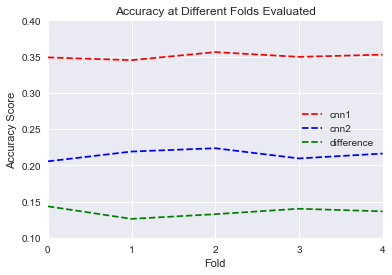

In [94]:
# Graph Accuracy score of two models -> DONE
import matplotlib.pyplot as plt

ax = plt.subplot()
plt.plot(cnn1_score, 'r--', label="cnn1")
plt.plot(cnn2_score, 'b--', label="cnn2")
plt.plot(cnn_diff, 'g--', label="difference")
plt.axis([0, 4,0.10, 0.40])
plt.xticks([0,1,2,3,4])

plt.legend()
plt.ylabel("Accuracy Score")
plt.xlabel("Fold")

plt.title("Accuracy at Different Folds Evaluated")
plt.show()

We can see that while the general trend of increase and decrease for both architectures are similar except for the fold 0, CNN1 performs much better overall. The difference of accuracy scores are maximized at fold 0, and minimized at fold 1. The best performance overall occurs at fold 2, and we have the accuracy of 0.356

### Compare performance to Standard MLP

In [80]:
# Use MLP
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

In [81]:
%%time
mlp.fit(X_train, y_train)

Wall time: 1min 49s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [100]:
# Tweak the graph function to be used with pickled data.
# TODO : Too much datapoints? -> Maybe just take the super class.
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(150,50))
    if cnn1_data is not None:

# This is me trying to call the score
# What would be the fold index? -> The best performance
        yhat_cnn = np.argmax(cnn1_data["fold_2"]["probas"], axis=1)
        acc_cnn = cnn1_data["fold_2"]["accuracy"]
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = mlp.predict(X_test)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)        
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

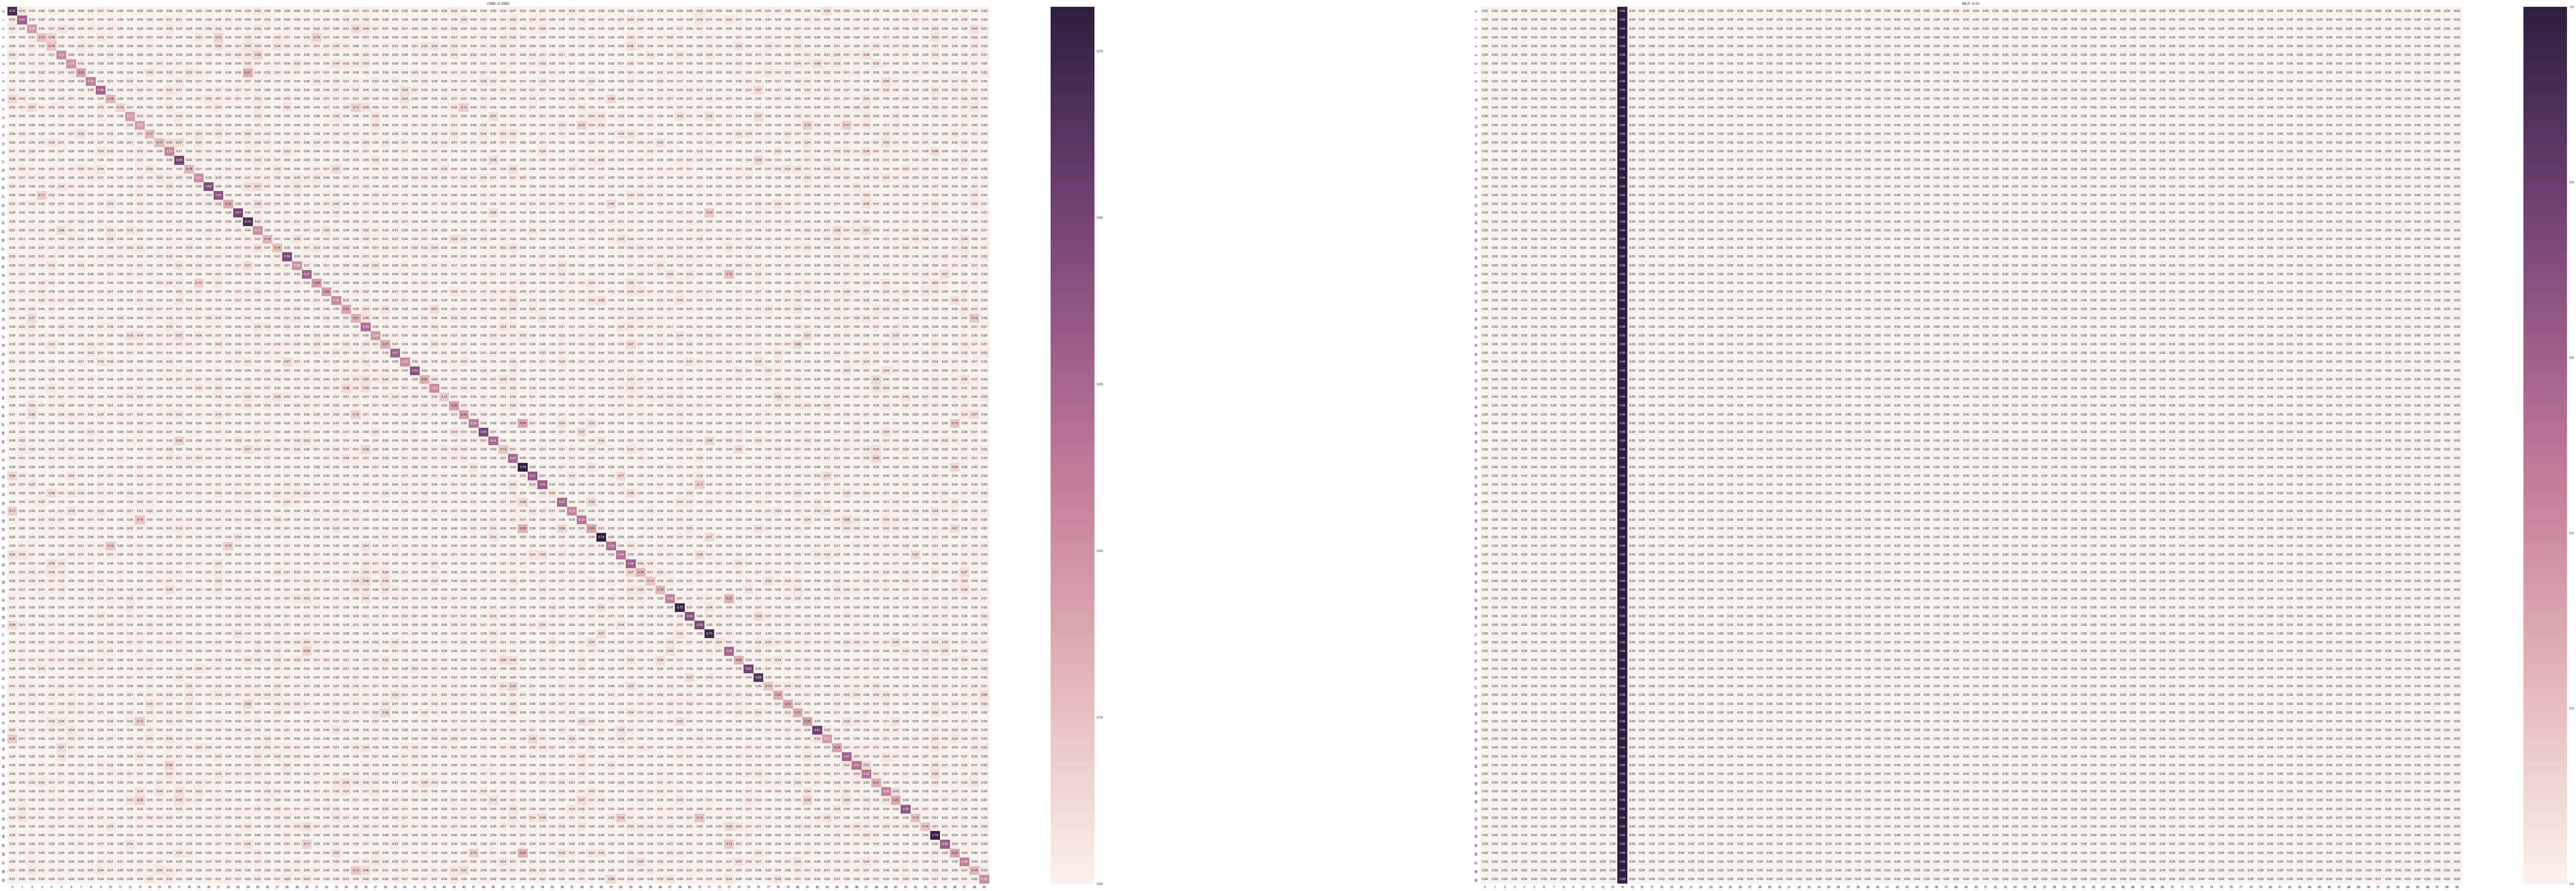

In [101]:
# Graph both for comparison in heatmap
compare_mlp_cnn(cnn1_data, mlp, X_validation, y_validation)

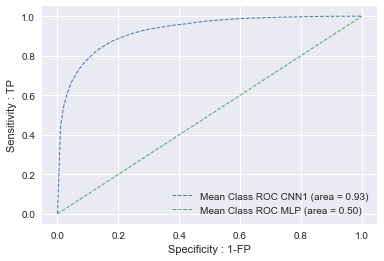

In [110]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
from scipy import interp

#build the prediction with best model
pred = cnn1_data["fold_2"]["probas"]
pred_mlp = mlp.predict_proba(X_validation)

K = 5

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

perclass_mean_tpr = 0.0
roc_auc = 0

classes = np.unique(y_train)
# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_validation,
#                                      typecast to integer
                                     pred[:,int(j)],
                                     pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

plt.figure(figsize=(6,4))
plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC CNN1 (area = %0.2f)'% (roc_auc))

perclass_mean_tpr = 0.0
roc_auc = 0

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_validation,
#                                      typecast to integer
                                     pred_mlp[:,int(j)],
                                     pos_label=j)
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC MLP (area = %0.2f)' % (roc_auc))

plt.legend(loc='best')
plt.xlabel('Specificity : 1-FP')
plt.ylabel('Sensitivity : TP')

With MLP having area of 0.50 and essentially guessing, we can see that the CNN will have better performance. In fact the CNN performs better or as well as the MLP at all thresholds.

## Exceptional Work

To create artificial variance in our data set and try to improve the generalization performance of our convolutional neural network, we used Keras's Image Data Generator to expand our data set by transforming our original data. Since an elastic deformation would not be as useful in this case as in character recognition, we stuck to simple translations, rotations, and scaling of our images to mimic photos taken in different positions.

In [70]:
import pandas as pd

# Preparing the data
X_train_expanded = X_train_scaled.reshape((50000, img_wh, img_wh, 3))
X_validation_expanded = X_validation_scaled.reshape((10000, img_wh, img_wh, 3))
                                       
y_train_expanded = y_train_ohe[:]
y_validation_expanded = y_validation_ohe[:]

In [71]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0,
    zoom_range=[0.2,0.2],
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    data_format="channels_last")

datagen.fit(X_train_expanded)

In [72]:
def create_cnn1_expanded():
    cnn = Sequential()

    num_filt_layers = [32, 64]
    for num_filters in num_filt_layers:
        cnn.add(Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        kernel_initializer='he_uniform',
                        padding='same', 
                        activation='relu',
                        input_shape=(img_wh,img_wh,3))) # more compact syntax

        # max pooling
        cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


    # add one layer on flattened output
    cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn.add(Flatten())
    cnn.add(Dense(1024, activation='relu'))
    cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn.add(Dense(NUM_CLASSES, activation='softmax'))
 
    cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                  optimizer='adam', # 'adadelta' 'rmsprop', 'adam'
                  metrics=['accuracy'])
    
    return cnn

In [ ]:
num_folds = 5
cnn1_expanded_data = {}

skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
for i, (train, test) in enumerate(skf.split(X_train_expanded, y_train)):
    fold_index = f"fold_{i}"
    
    print(f"Fold {i}")
    cnn1 = create_cnn1_expanded()
    cnn1.fit(X_train_expanded[train], y_train_expanded[train], 
            batch_size=128, epochs=15, 
            shuffle=True, verbose=1,
            validation_data=(X_train_expanded[test],y_train_expanded[test]))
    
    cnn1_expanded_data[fold_index] = {}
    cnn1_expanded_data[fold_index]["train_indices"] = train
    cnn1_expanded_data[fold_index]["test_indices"] = test
    cnn1_expanded_data[fold_index]["probas"] = cnn1.predict_proba(X_validation_expanded)
    
    yhat = np.argmax(cnn1.predict(X_validation_expanded), axis=1)
    print (yhat)
    acc = mt.accuracy_score(y_validation,yhat)
    cnn1_expanded_data[fold_index]["accuracy"] = acc
    

with open('cnn1_expanded_data.pickle', 'wb') as handle:
    pickle.dump(cnn1_expanded_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
with open('cnn1_expanded_data.pickle', 'wb') as handle:
    pickle.dump(cnn1_expanded_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# Run this cell if you haven't run the above model
with open('cnn1_expanded_data.pickle', 'rb') as handle:
    cnn1_expanded_data = pickle.load(handle)
# print(cnn1_expanded_data)

In [80]:
cnn1_expanded_score = []
cnn_diff = []
for i in range (0,5) :

    cnn1_expanded_score.append(cnn1_expanded_data["fold_"+str(i)]["accuracy"])
    cnn_diff.append(
        cnn1_score[i] - 
        cnn1_expanded_data["fold_"+str(i)]["accuracy"])

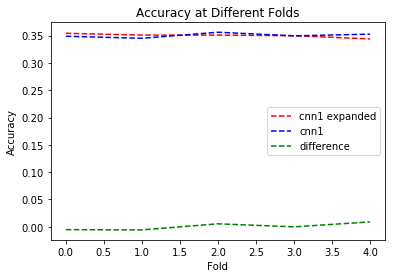

In [81]:
ax = plt.subplot()
plt.plot(cnn1_expanded_score, 'r--', label="cnn1 expanded")
plt.plot(cnn1_score, 'b--', label="cnn1")
plt.plot(cnn_diff, 'g--', label="difference")

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Fold")

plt.title("Accuracy at Different Folds")
plt.show()

From this graph, we can see that there is basically no improvement with data expansion. We think that the biggest problem is with the filter size. We don't think that there is enough overlap on the filters because of the larger size of the image and so any expansions of the data wouldn't pick up much of a difference.

We are also dealing with a lot of data and a lot of class labels as well so there wasn't really a chance for our first cnn architecture to have overfit in the first place.